# 05: Spatial Trends and Regressions

Although it is often enough to work with one-dimensional time series, sometimes we want to be able to visualize the evolution (or co-evolution) of time-varying spatial distributions. This fifth stage of the tutorial demonstrates how to construct spatial distributions of trends, spatial distributions of correlations with one-dimensional time series, and regressions onto one-dimensional time series. These examples also demonstrate ways to link xarray objects from different sources for analysis.

In [1]:
!pip install colormaps cartopy gdown
import numpy as np
import xarray as xr
import pandas as pd
from scipy.stats import linregress
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeat
import cartopy.util as cputil
import colormaps

import warnings
warnings.filterwarnings('ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.9/727.9 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 75.1 MB/s eta 0:00:00


Read in data. Here we use the surface air temperatures again:

In [4]:
!gdown {'1sfL2pGgq2kZD-0oYc15PcNNpv-cN4ppv'}

Downloading...
From: https://drive.google.com/uc?id=1sfL2pGgq2kZD-0oYc15PcNNpv-cN4ppv
To: /content/ERA5_surface_common-grid_monthly_t2m_1940-2024.nc
100% 43.0M/43.0M [00:00<00:00, 116MB/s]


In [5]:
tas = xr.open_dataset('ERA5_surface_common-grid_monthly_t2m_1940-2024.nc')['t2m']

---
### Trends

The following function wraps [scipy.stats.linregress()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html) for easier use with xarray DataArray objects.

- Option: adjust this function to use a different regression tool.

In [6]:
def regress(x, y):
    if np.isnan(y).all():
        return np.nan, np.nan, np.nan, np.nan, np.nan
    else:
        return linregress(x, y)

We select the period after 1950 when observations are [more reliable](https://doi.org/10.1002/2013RG000434). Trends are also larger after 1950, as shown in [part 4](04-WeightsAndRolls.ipynb) of these tutorials. The mean seasonal cycle over 1950-2024 is subtracted to compute anomalies. We then select annual mean anomalies for the January-March and July-September seasons.

- Option: chop and select different months, seasons, or periods to compute the trends.

In [7]:
# Trends over 1940-2024
sst_anm = tas.groupby('time.month') - tas.groupby('time.month').mean('time')

# Use JFM and JAS for winter and summer trends (same number of years in each sample)
tas_jfm = tas.sel(time=sst_anm.time.dt.month.isin([1,2,3])).groupby('time.year').mean('time')
tas_jas = tas.sel(time=sst_anm.time.dt.month.isin([7,8,9])).groupby('time.year').mean('time')

# Create a dummy index to use for calculating the trend
times = xr.DataArray(np.arange(85), coords={'year': tas_jfm.year}, dims=['year'])

For convenience and readability, it is often useful to use the [xarray.apply_ufunc()](https://docs.xarray.dev/en/stable/generated/xarray.apply_ufunc.html) interface to apply functions along a given dimension. You can define the function yourself or use functions from numpy, scipy, or other modules compatible with xarray. The result contains the standard outputs of [scipy.stats.linregress()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html) (slope, intercept, Pearson's correlation coefficient, *p* value, and standard error of the slope) at all grid locations. Each of these return values is a DataArray with dimensions of latitude and longitude.
- [A gentle introduction to apply_ufunc](https://tutorial.xarray.dev/advanced/apply_ufunc/simple_numpy_apply_ufunc.html)

In [8]:
# Summer and winter trends, 1950-2024
rgr_jfm = xr.apply_ufunc(regress, times, tas_jfm, input_core_dims=[['year'], ['year']],
                         output_core_dims=[[], [], [], [], []], vectorize=True)
rgr_jas = xr.apply_ufunc(regress, times, tas_jas, input_core_dims=[['year'], ['year']],
                         output_core_dims=[[], [], [], [], []], vectorize=True)

We then plot the distributions.
- Option: play around with the projections and area selection

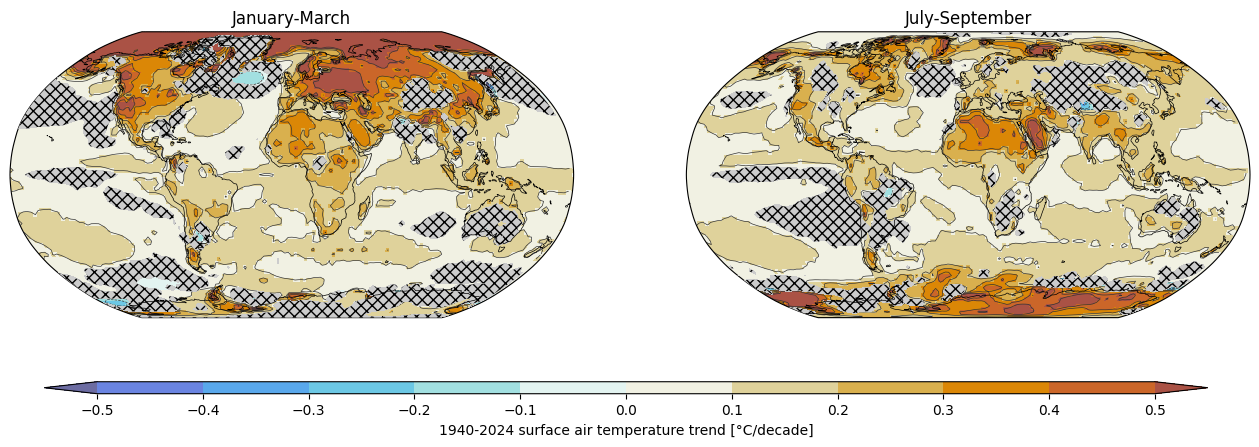

In [9]:
pv = 0.05

# Make the plot
fig = plt.figure(figsize=(16,6))
axa = fig.add_subplot(121, projection=ccrs.Robinson())
axb = fig.add_subplot(122, projection=ccrs.Robinson())
clrs = colormaps.prinsenvlag_r

# Levels and contour lines (same for all panels)
dlv = [-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5]
llv = [-0.5, -0.4, -0.3, -0.2, -0.1, 0.1, 0.2, 0.3, 0.4, 0.5]
lls = ['--', '--', '--', '--', '--', '-', '-', '-', '-', '-']

# Plotting parameters
cax = fig.add_axes([0.11, 0.13, 0.8, 0.02]) # In this case, with multiple plots, we define an axis for the shared colorbar
cbkws = {'label': '1940-2024 surface air temperature trend [°C/decade]', 'orientation': 'horizontal', 'ticks': dlv}
kwrgs = {'cmap': clrs, 'levels': dlv, 'extend': 'both', 'transform': ccrs.PlateCarree(), 'cbar_ax': cax, 'cbar_kwargs': cbkws}
lwrgs = {'levels': llv, 'colors': ['#333'], 'transform': ccrs.PlateCarree(), 'linestyles': lls, 'linewidths': [0.5]}

# Plot the data for p value < 0.01
(10*rgr_jfm[0]).plot(ax=axa, **kwrgs)
(10*rgr_jfm[0]).plot.contour(ax=axa, **lwrgs)
rgr_jfm[3].plot.contourf(ax=axa, hatches=['xxx'], levels=[pv, 1], colors=['#ccc'], extend='neither', add_colorbar=False,
                         transform=ccrs.PlateCarree(), zorder=4)
(10*rgr_jas[0]).plot(ax=axb, **kwrgs)
(10*rgr_jas[0]).plot.contour(ax=axb, **lwrgs)
rgr_jas[3].plot.contourf(ax=axb, hatches=['xxx'], levels=[pv, 1], colors=['#ccc'], extend='neither', add_colorbar=False,
                         transform=ccrs.PlateCarree(), zorder=4)

# Clean up
for ax in [axa, axb]:
    ax.add_feature(cfeat.COASTLINE, linewidth=0.5, zorder=8)

axa.set_title('January-March')
axb.set_title('July-September')

plt.show()

Here we have used the *p*-value DataArray returned from the regress() function to mask areas with *p* ≥ pv, which is set to 0.05 in the first line of the block. Filled contours can be hatched as shown in the example. Trends in deseasonalized sea surface temperature anomalies are larger in the summer hemisphere.

- Option: change the threshold $p$ value.
- Option: change the code to apply a different test of statistical significance

---
### Correlation

In this section, we demonstrate how to construct a map of correlations between a geospatial field and a one-dimensional time series. The [Tropical North Atlantic](https://psl.noaa.gov/data/timeseries/month/DS/TNA/) index discussed in the previous example and the [Oceanic Nino Index](https://psl.noaa.gov/data/timeseries/month/DS/ONI/) representing tropical Pacific variability are combined with rainfall estimates from the [Global Precipitation Climatology Project](https://psl.noaa.gov/data/gridded/data.gpcp.html) index for the period 1979-2024.

First we read in the TNA and ONI time series, which is contained in a text file. There are many ways to access such files in python, but the easiest if we are planning to use xarray is to combine [pandas.read_csv()](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html) with the [pandas.DataFrame.to_xarray()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_xarray.html) method.

In [12]:
!gdown {'1ighUDD_r2PE063Rl8cb6maUwWDvCEWhT'}
!gdown {'1-C8NHrCWdyLexyKsENDJUqFx1c2OsUjR'}
!gdown {'17Vr1s0HJGLJVvLlJC0bx64WUJx04d9wF'}
!gdown {'1YW1Dr_Y2aPa5z8XzyPtTg5OZFm9OBHne'}

Downloading...
From: https://drive.google.com/uc?id=1ighUDD_r2PE063Rl8cb6maUwWDvCEWhT
To: /content/tna.csv
100% 19.7k/19.7k [00:00<00:00, 42.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-C8NHrCWdyLexyKsENDJUqFx1c2OsUjR
To: /content/oni.ascii.txt
100% 24.6k/24.6k [00:00<00:00, 51.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=17Vr1s0HJGLJVvLlJC0bx64WUJx04d9wF
To: /content/tna_timeseries.nc
100% 158k/158k [00:00<00:00, 90.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1YW1Dr_Y2aPa5z8XzyPtTg5OZFm9OBHne
To: /content/precip_GPCPv2-7_mon_1979-2024.nc
100% 23.0M/23.0M [00:00<00:00, 78.2MB/s]


In [13]:
tna_ix = pd.read_csv('tna.csv', index_col=0).to_xarray()
tna_ix

<xarray.Dataset> Size: 15kB
Dimensions:  (Date: 936)
Coordinates:
  * Date     (Date) object 7kB '1948-01-01' '1948-02-01' ... '2025-12-01'
Data variables:
       TNAa  (Date) float64 7kB 0.16 -0.01 0.25 ... -9.999e+03 -9.999e+03

In [14]:
ensoix = pd.read_csv('oni.ascii.txt', index_col=0).to_xarray()
ensoix

<xarray.Dataset> Size: 22kB
Dimensions:   (SEASYR: 909)
Coordinates:
  * SEASYR    (SEASYR) object 7kB '  DJF 1950' '  JFM 1950' ... '  ASO 2025'
Data variables:
       TOTAL  (SEASYR) float64 7kB 24.72 25.17 25.75 26.12 ... 27.11 26.63 26.31
       ANOM   (SEASYR) float64 7kB -1.53 -1.34 -1.16 -1.18 ... -0.19 -0.32 -0.45

We'll now load the principal component time series from the [previous notebook](04-WeightsAndRolls.ipynb), as well as global monthly-mean precipitation from GPCP.

In [15]:
atl_ts = xr.open_dataset('tna_timeseries.nc')

In [16]:
prc = xr.open_dataset('precip_GPCPv2-7_mon_1979-2024.nc')['precip']
prc

<xarray.DataArray 'precip' (time: 552, lat: 72, lon: 144)> Size: 23MB
[5723136 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 4kB 1979-01-01 1979-02-01 ... 2024-12-01
  * lat      (lat) float32 288B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * lon      (lon) float32 576B 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
Attributes:
    long_name:                Average Monthly Rate of Precipitation
    units:                    mm/day
    precision:                32767
    least_significant_digit:  2
    var_desc:                 Precipitation
    dataset:                  GPCP Version 2.3 Combined Precipitation Dataset
    level_desc:               Surface
    statistic:                Mean
    parent_stat:              Mean
    actual_range:             [0.000000e+00 1.365714e+13]

We compute correlation distributions for the late spring (April-May) "mango rains" against these SST indices for the Northern Hemisphere spring (March-April-May).

- Option: change the selected periods or seasons. How sensitive are the results to these choices?

In [17]:
tna_ix = xr.DataArray(tna_ix['   TNAa'].sel(Date=slice('1979-01-01', '2024-12-01')),
                      dims=['time'], coords={'time': prc.time.values})
ensoix = xr.DataArray(ensoix['   ANOM'].sel(SEASYR=slice('  DJF 1979', '  NDJ 2024')),
                      dims=['time'], coords={'time': prc.time.values})

In [18]:
tnax = tna_ix.sel(time=(tna_ix.time.dt.season=='MAM')).groupby('time.year').mean('time')
atl3 = atl_ts['modes'].sel(mode=1, time=(atl_ts.time.dt.season=='MAM')).groupby('time.year').mean('time')
enso = ensoix.sel(time=(ensoix.time.dt.season=='MAM')).groupby('time.year').mean('time')

SST is subject to large trends (see [part 4](04-WeightsAndRolls.ipynb)). In this case, because we are using the shorter 1979-2024 period, linear trends are more reasonable than they were in that example (1850-2024). Here we define a simple function to calculate a polynomial trend from a time series.

In [19]:
def trend(da, dim='time', deg=1):
    # calculate the trend along a single dimension
    p = da.polyfit(dim=dim, deg=deg) # least squares fit for a polynomial of degree deg
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return fit

And apply it to remove any linear trends from the SST indices.

- Option: some published SST indices are already detrended. Do you think these index time series have been detrended?
- Option: use higher-order polynomials instead. Are the results sensitive to this choice? Is linear regression appropriate in this case?

In [20]:
# Detrend SSTs
tnax = tnax - trend(tnax, dim='year', deg=1)
enso = enso - trend(enso, dim='year', deg=1)

The other SST time series is already detrended. Next we select only the April-May precipitation and detrend it as well.

- Option: do you need to detrend the precipitation? How could you evaluate this?

In [21]:
prc_am = prc.isel(time=(prc.time.dt.month.isin([4,5]))).groupby('time.year').mean('time')
prc_am_dt = prc_am - trend(prc_am, dim='year', deg=1)

We then compute the correlation distributions using [xarray.corr()](https://docs.xarray.dev/en/stable/generated/xarray.corr.html) along the common "year" dimension.

In [22]:
tnax_crr = xr.corr(prc_am_dt, tnax, dim='year')
atl3_crr = xr.corr(prc_am_dt, atl3, dim='year')
enso_crr = xr.corr(prc_am_dt, enso, dim='year')

Finally, we plot the correlation maps as a multi-panel figure.

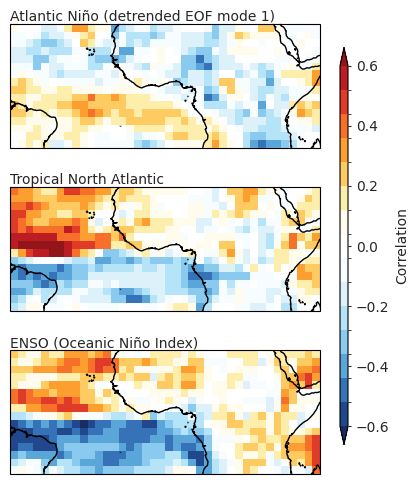

In [23]:
sns.set_style('white', {"axes.edgecolor": "k"})

# contour levels
clv = np.linspace(-0.6,0.6,16)
lls = ['--']*8 + ['-']*8

# Set figure style
proj = ccrs.PlateCarree(central_longitude=0)

fig = plt.figure(figsize=(4,6))
axa = fig.add_subplot(311, projection=proj)
axb = fig.add_subplot(312, projection=proj)
axc = fig.add_subplot(313, projection=proj)

cbx = fig.add_axes([0.95, 0.1, 0.02, 0.8]) # In this case, with multiple plots, we define an axis for the shared colorbar
cbkws = {'label': 'Correlation', 'orientation': 'vertical', 'ticks': [-0.6,-0.4,-0.2,0,0.2,0.4,0.6]}
kwrgs = {'cmap': colormaps.BlueWhiteOrangeRed, 'levels': clv, 'extend': 'both', 'transform': ccrs.PlateCarree(), 'cbar_ax': cbx, 'cbar_kwargs': cbkws}
lwrgs = {'levels': clv, 'colors': ['#666666'], 'transform': ccrs.PlateCarree(), 'linestyles': lls, 'linewidths': [0.4], 'zorder': 5}

atl3_crr.plot(ax=axa, **kwrgs)

tnax_crr.plot(ax=axb, **kwrgs)

enso_crr.plot(ax=axc, **kwrgs)

axa.set_title('')
axa.text(0, 1, 'Atlantic Niño (detrended EOF mode 1)', ha='left', va='bottom', transform=axa.transAxes)
axb.text(0, 1, 'Tropical North Atlantic', ha='left', va='bottom', transform=axb.transAxes)
axc.text(0, 1, 'ENSO (Oceanic Niño Index)', ha='left', va='bottom', transform=axc.transAxes)
cbx.tick_params(length=2, which='both')

for ax in [axa, axb, axc]:
    ax.coastlines(zorder=10)
    ax.set_extent([-50, 50, -15, 25], crs=proj)

None of these indices has a strong simultaneous correlation with the pre-monsoon rains in West Africa, suggesting that we may need to look at other metrics to identify key drivers of interannual variability in this transitional season rainfall.

- Option: You might also notice that the patterns are similar between correlations with TNA and correlations with ENSO. Are these two indices strongly correlated over this period?

---
### Regression

As a last example, we can evaluate how the mango rains have responded to long-term trends and low-frequency variability in Atlantic SST. Ideally we would use a longer time series of precipitation, so we replace GPCP with the [JRA-3Q reanalysis](https://jra.kishou.go.jp/JRA-3Q/index_en.html), which uses the COBE2 SST as a lower boundary condition (**note: reanalysis precipitation fields are not reliable for long-term variability or trends!** JRA-3Q is used here only for illustration). Here, we use the EEOF-based estimate of the trend, normalized to an area-mean increase of 1°C in the analysis domain:

In [24]:
!gdown {'1gXuobchL7zcAUSZAfyHqLv-wtLz5jQjS'}
!gdown {'1PlilgoIiyDkMDLio4jbnJ-BxyCTWbNG-'}
!gdown {'1w_uKtqvEnRQULA7k4Q1oT85ulQ-OWCVg'}

Downloading...
From: https://drive.google.com/uc?id=1gXuobchL7zcAUSZAfyHqLv-wtLz5jQjS
To: /content/JRA-3Q_surface_common-grid_monthly_precip_1950-2024.nc
100% 37.0M/37.0M [00:00<00:00, 109MB/s]
Downloading...
From: https://drive.google.com/uc?id=1PlilgoIiyDkMDLio4jbnJ-BxyCTWbNG-
To: /content/ERA5_surface_common-grid_monthly_pr_1940-2024.nc
100% 41.8M/41.8M [00:00<00:00, 60.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1w_uKtqvEnRQULA7k4Q1oT85ulQ-OWCVg
To: /content/precip_CMAP_mon_1979-2024.nc
100% 16.6M/16.6M [00:00<00:00, 34.6MB/s]


In [25]:
j3pr = xr.open_dataset('JRA-3Q_surface_common-grid_monthly_precip_1950-2024.nc')['tprate1have-sfc-fc-ll125']
# convert from mm/s to mm/day
j3pr_am = 86400 * j3pr.isel(time=(j3pr.time.dt.month.isin([4,5]))).groupby('time.year').mean('time')

In [26]:
trnd = atl_ts['trend'].sel(time=atl_ts.time.dt.month.isin([4,5])).groupby('time.year').mean('time').dropna('year')
trnd_s = trnd/1000 # approximate adjustment factor from previous notebook to tie a value of 1 to a 1°C SST increase

After trimming the time indices for both variables to match each other (necessary to apply_ufunc along that axis), we can regress precipitation onto the trend:

- Option: try different time periods (note: the JRA-3Q data start from 1950 and the PC time series ends in 2019)

In [27]:
# Trim precipitation to match (reanalyses are especially unreliable before 1958)
trnd_s = trnd_s.sel(year=slice(1960,2019))
prcx = j3pr_am.sel(year=slice(1960,2019))

In [28]:
# Standardize trend to a ~1°C area-mean change in the full domain
rgr_mr = xr.apply_ufunc(regress, trnd_s, prcx, input_core_dims=[['year'], ['year']],
                        output_core_dims=[[], [], [], [], []], vectorize=True)

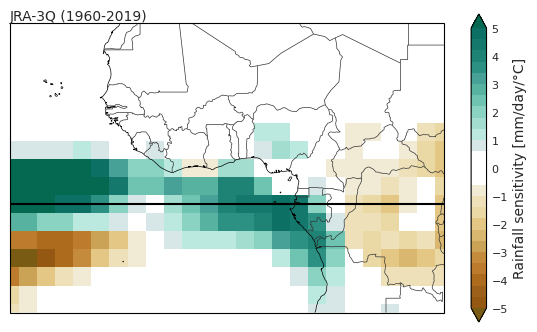

In [29]:
fig = plt.figure(figsize=(7,4))
axs = fig.add_subplot(111, projection=ccrs.PlateCarree()) # Recenter on the Atlantic

cbkws = {'label': 'Rainfall sensitivity [mm/day/°C]', 'orientation': 'vertical', 'ticks': [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]}
clrs = colormaps.NEO_div_vegetation_c  # https://pratiman-91.github.io/colormaps/docs/Other#cubehelix-schemes
clrs.colors[115:141] = [(1,1,1)]*26
clev = np.linspace(-5, 5, 26)
kwrgs = {'cmap': clrs, 'levels': clev, 'extend': 'both', 'transform': ccrs.PlateCarree(), 'add_colorbar': True, 'cbar_kwargs': cbkws}

slp = rgr_mr[0]
slp = slp.where(rgr_mr[3] < 0.01, np.nan)
c = rgr_mr[0].plot(ax=axs, **kwrgs)

axs.text(0,1,'JRA-3Q (1960-2019)', ha='left', va='bottom', transform=axs.transAxes)
axs.coastlines(color='k', lw=0.5)
axs.add_feature(cfeat.BORDERS, color='#333', lw=0.5)
axs.set_title('')
c.colorbar.ax.tick_params(labelsize=8, length=0, which='both')

# to plot just a specific region
axs.set_extent([-30, 30, -15, 25], crs=ccrs.PlateCarree())
axs.axhline(0, color='k')

plt.show()
plt.close(fig)

JRA-3Q indicates a very large sensitivity to the trend pattern, especially over ocean regions, with a north-south dipole in the Atlantic and an east-west dipole between the Gulf of Guinea and central Africa. For reference, Atlantic SST change from the pre-industrial baseline (based on this low-frequency mode) varied from roughly 0.5 to 0.6°C over the 2010-2019 period. How does JRA-3Q compare to other datasets?

We start by comparing JRA-3Q with another state-of-the-art reanalysis, ERA5.

In [30]:
e5pr = xr.open_dataset('ERA5_surface_common-grid_monthly_pr_1940-2024.nc')['pr']
# convert from mm/s to mm/day
e5pr_am = 86400 * e5pr.isel(time=(e5pr.time.dt.month.isin([4,5]))).groupby('time.year').mean('time')

In [31]:
# Use the same period as for JRA-3Q
trnd_s = trnd_s.sel(year=slice(1979,2019))
prcx = e5pr_am.sel(year=slice(1979,2019))

rgr_mr = xr.apply_ufunc(regress, trnd_s, prcx, input_core_dims=[['year'], ['year']],
                        output_core_dims=[[], [], [], [], []], vectorize=True)

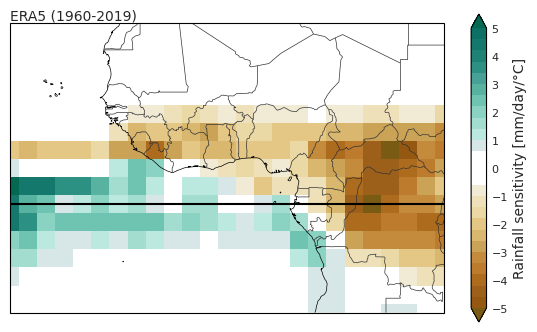

In [32]:
fig = plt.figure(figsize=(7,4))
axs = fig.add_subplot(111, projection=ccrs.PlateCarree()) # Recenter on the Atlantic

cbkws = {'label': 'Rainfall sensitivity [mm/day/°C]', 'orientation': 'vertical', 'ticks': [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]}
clev = np.linspace(-5, 5, 26)
kwrgs = {'cmap': clrs, 'levels': clev, 'extend': 'both', 'transform': ccrs.PlateCarree(), 'add_colorbar': True, 'cbar_kwargs': cbkws}

slp = rgr_mr[0]
slp = slp.where(rgr_mr[3] < 0.01, np.nan)
c = rgr_mr[0].plot(ax=axs, **kwrgs)

axs.text(0,1,'ERA5 (1960-2019)', ha='left', va='bottom', transform=axs.transAxes)
axs.coastlines(color='k', lw=0.5)
axs.add_feature(cfeat.BORDERS, color='#333', lw=0.5)
axs.set_title('')
c.colorbar.ax.tick_params(labelsize=8, length=0, which='both')

# to plot just a specific region
axs.set_extent([-30, 30, -15, 25], crs=ccrs.PlateCarree())
axs.axhline(0, color='k')

plt.show()
plt.close(fig)

ERA5 shows much more drying throughout the domain in April-May, especially over West Africa.

- Option: plot the difference between results based on JRA-3Q and results based on ERA5

Let's finish by seeing how the patterns in the reanalyses compare to observation-based analyses, which only cover the period after 1979. We start with GPCP, the satellite and gauge-based analysis we used above:

In [33]:
# GPCP time series is already loaded
trnd_s = trnd_s.sel(year=slice(1979,2019))
prcx = prc_am.sel(year=slice(1979,2019))

rgr_mr = xr.apply_ufunc(regress, trnd_s, prcx, input_core_dims=[['year'], ['year']],
                        output_core_dims=[[], [], [], [], []], vectorize=True)

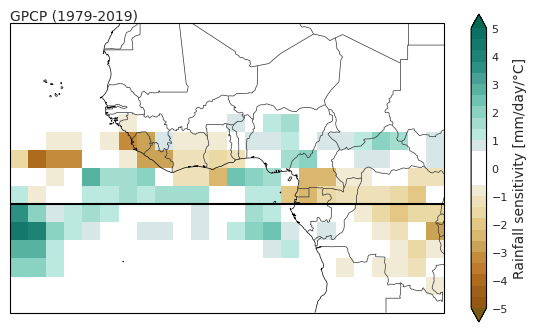

In [34]:
fig = plt.figure(figsize=(7,4))
axs = fig.add_subplot(111, projection=ccrs.PlateCarree()) # Recenter on the Atlantic

cbkws = {'label': 'Rainfall sensitivity [mm/day/°C]', 'orientation': 'vertical', 'ticks': [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]}
clev = np.linspace(-5, 5, 26)
kwrgs = {'cmap': clrs, 'levels': clev, 'extend': 'both', 'transform': ccrs.PlateCarree(), 'add_colorbar': True, 'cbar_kwargs': cbkws}

slp = rgr_mr[0]
slp = slp.where(rgr_mr[3] < 0.01, np.nan)
c = rgr_mr[0].plot(ax=axs, **kwrgs)

axs.text(0,1,'GPCP (1979-2019)', ha='left', va='bottom', transform=axs.transAxes)
axs.coastlines(color='k', lw=0.5)
axs.add_feature(cfeat.BORDERS, color='#333', lw=0.5)
axs.set_title('')
c.colorbar.ax.tick_params(labelsize=8, length=0, which='both')

# to plot just a specific region
axs.set_extent([-30, 30, -15, 25], crs=ccrs.PlateCarree())
axs.axhline(0, color='k')

plt.show()
plt.close(fig)

Unlike the reanalysis products, GPCP shows some evidence of the ["split dipole"](https://doi.org/10.1016/B978-0-44-314050-1.00011-6) pattern mentioned by Prof. Wane in reference to future projections on Monday, although the implied changes are relatively weak and the spatial pattern appears noisy.

The final dataset considered here is the [CMAP monthly precipitation](https://psl.noaa.gov/data/gridded/data.cmap.html) product, another satellite and gauge-based analysis in the same vein as GPCP.

In [35]:
cprc = xr.open_dataset('precip_CMAP_mon_1979-2024.nc')['precip']
cprc_am = cprc.isel(time=(cprc.time.dt.month.isin([4,5]))).groupby('time.year').mean('time')

In [36]:
trnd_s = trnd_s.sel(year=slice(1979,2019))
prcx = cprc_am.sel(year=slice(1979,2019))

rgr_mr = xr.apply_ufunc(regress, trnd_s, prcx, input_core_dims=[['year'], ['year']],
                        output_core_dims=[[], [], [], [], []], vectorize=True)

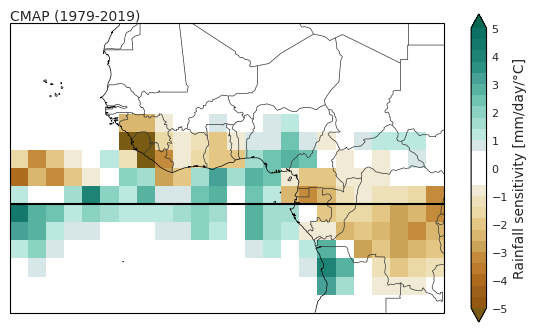

In [37]:
fig = plt.figure(figsize=(7,4))
axs = fig.add_subplot(111, projection=ccrs.PlateCarree()) # Recenter on the Atlantic

cbkws = {'label': 'Rainfall sensitivity [mm/day/°C]', 'orientation': 'vertical', 'ticks': [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]}
clev = np.linspace(-5, 5, 26)
kwrgs = {'cmap': clrs, 'levels': clev, 'extend': 'both', 'transform': ccrs.PlateCarree(), 'add_colorbar': True, 'cbar_kwargs': cbkws}

slp = rgr_mr[0]
slp = slp.where(rgr_mr[3] < 0.01, np.nan)
c = rgr_mr[0].plot(ax=axs, **kwrgs)

axs.text(0,1,'CMAP (1979-2019)', ha='left', va='bottom', transform=axs.transAxes)
axs.coastlines(color='k', lw=0.5)
axs.add_feature(cfeat.BORDERS, color='#333', lw=0.5)
axs.set_title('')
c.colorbar.ax.tick_params(labelsize=8, length=0, which='both')

# to plot just a specific region
axs.set_extent([-30, 30, -15, 25], crs=ccrs.PlateCarree())
axs.axhline(0, color='k')

plt.show()
plt.close(fig)

CMAP is generally consistent with GPCP, but with signals that appear slightly more coherent. The clear discrepancies between the observationally-based analyses (GPCP and CMAP) and the reanalysis products (JRA-3Q and ERA5), as well as the discrepancies between the two reanalysis products themselves (try limiting JRA-3Q and ERA5 to 1979-2019 instead for an especially stark example!), illustrate the problems with using reanalysis precipitation products for low-frequency variability and trends.